In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import os

In [2]:
def discrete_cmap():
    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
    cpool = ['#DCDCDC', '#b3de69', '#000000', '#8dd3c7', '#fdb462',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d', '#ffffb3']
    cmap3 = colors.ListedColormap(cpool, 'rooms')
    cm.register_cmap(cmap=cmap3)

    cpool = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d']
    cmap3 = colors.ListedColormap(cpool, 'icons')
    cm.register_cmap(cmap=cmap3)

    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
    cpool = ['#DCDCDC', '#b3de69', '#000000', '#8dd3c7', '#fdb462',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d', '#ffffb3', 'd3d5d7']
    cmap3 = colors.ListedColormap(cpool, 'rooms_furu')
    cm.register_cmap(cmap=cmap3)

    cpool = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
             '#fccde5', '#80b1d3', '#808080', '#fb8072', '#696969',
             '#577a4d']
    cmap3 = colors.ListedColormap(cpool, 'rooms_furu')
    cm.register_cmap(cmap=cmap3)
discrete_cmap()

/tmp/ipykernel_5563/2660030060.py:28: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)


In [3]:
data_path = '../../CubiCasa5k/data/cubicasa5k/'
with open(data_path + 'test.txt') as f: files = [f'{data_path}{n[1:-1]}F1_original.png'  for n in f.readlines()]
print('\n'.join(f'{i}, {f}' for i,f in enumerate(files[:10])))

0, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/1191/F1_original.png
1, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2536/F1_original.png
2, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2530/F1_original.png
3, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2504/F1_original.png
4, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2207/F1_original.png
5, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/22/F1_original.png
6, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2090/F1_original.png
7, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2085/F1_original.png
8, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2014/F1_original.png
9, ../../CubiCasa5k/data/cubicasa5k/high_quality_architectural/2011/F1_original.png


In [4]:
## Warmup run
from brute_force import recognize
from recognition import *
import time

verbose = False

image_name = files[0]
path = f'./qualitative/{"-".join(image_name.split("/")[-3:-1])}/'
original = cv2.imread(image_name)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

prediction = recognize(original, verbose)
walls, doors, windows, segmentation = prediction['walls'], prediction['doors'], prediction['windows'], prediction['segmentation']
walls = attach_openings(walls, doors + windows, verbose)
walls = calculate_wall_widths(walls, prediction['segmentation']['walls'], verbose)
walls = normalize_wall_points(walls, walls, 5)
walls = classify_wall_elements(walls, original, verbose)
symbols = classify_symbols(prediction['symbols'], original, verbose)

In [7]:
out_file = './qualitative/all_times_all_gpu.csv'
# with open(out_file, 'w') as f: f.write('i,area,seg,vect,wall_width,smbl_class,att,norm,att+norm,total\n')

for i, image_name in tqdm(enumerate(files[:100])):

    if i < 81:
        continue

    path = f'./qualitative/{"-".join(image_name.split("/")[-3:-1])}/'
    original = cv2.imread(image_name)
    try:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    except:
        original = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)

    with open(out_file, 'a') as f:
        prediction = recognize(original, verbose)
        f.write(f'{i},')
        f.write(f'{original.shape[0]*original.shape[1]},')
        f.write(f'{prediction["times"]["segmentation"]},')
        f.write(f'{prediction["times"]["vectorization"]},')

        walls, doors, windows, segmentation = prediction['walls'], prediction['doors'], prediction['windows'], prediction['segmentation']

        start = time.perf_counter()
        walls = attach_openings(walls, doors + windows, verbose)
        attach_time = time.perf_counter() - start

        start = time.perf_counter()
        walls = calculate_wall_widths(walls, prediction['segmentation']['walls'], verbose)
        wall_width_time = time.perf_counter() - start
        f.write(f'{wall_width_time},')

        start = time.perf_counter()
        walls = normalize_wall_points(walls, walls, 5)
        normalize_time = time.perf_counter() - start

        start = time.perf_counter()
        walls = classify_wall_elements(walls, original, verbose)
        symbols = classify_symbols(prediction['symbols'], original, verbose)
        symbol_class_time = time.perf_counter() - start
        f.write(f'{symbol_class_time},')

        f.write(f'{attach_time},{normalize_time},{attach_time+normalize_time},')

        total_time = prediction["times"]["segmentation"] + prediction["times"]["vectorization"]+attach_time+wall_width_time+normalize_time+symbol_class_time
        f.write(f'{total_time}\n')

    res = {'walls': walls, 'symbols': symbols}



100it [01:43,  1.04s/it]


In [8]:
image_name = files[80]
original = cv2.imread(image_name)
print(original.shape)


(1528, 1508, 3)


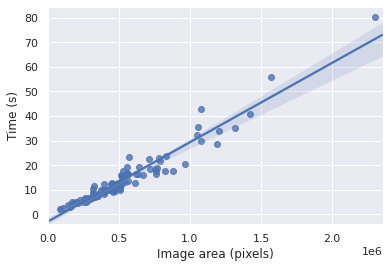

(0.0, 84.3799688498647)

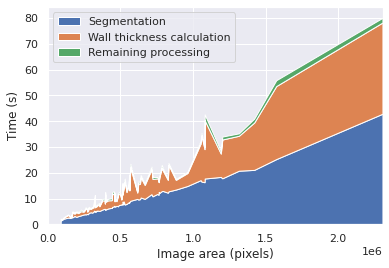

In [9]:
import pandas as pd
import seaborn as sns

sns.set_theme()

times = pd.read_csv('./qualitative/all_times.csv')
# times = pd.read_csv(out_file)
times.sort_values(by='area', inplace=True)
M = times.area.max()

plt.xlim((0, M+0.05e6))
plt.ylim((-4, 84.3799688498647))
sns.regplot(x='area', y='total', data=times, label='Total', truncate=False)
plt.ylabel('Time (s)')
plt.xlabel('Image area (pixels)')
# plt.savefig('./qualitative/time-by-area-cpu.pdf', bb_inches='tight', pad_inches=0)
plt.show()

remaining = times.vect + times["att+norm"] + times.smbl_class

plt.stackplot(
    times.area, times.seg, times.wall_width, remaining, 
    labels=['Segmentation', 'Wall thickness calculation', 'Remaining processing'])
plt.legend(loc='upper left')
plt.ylabel('Time (s)')
plt.xlabel('Image area (pixels)')
plt.xlim((0, M))
plt.ylim((0, 84.3799688498647))
# plt.savefig('./qualitative/stacked-time-by-area-cpu.pdf', bb_inches='tight', pad_inches=0)

In [10]:
times = times[:-1]
times["seg/total"] = times.seg/times.total * 100
times["width/total"] = times.wall_width/times.total * 100
times["smbl_class/total"] = times.smbl_class/times.total * 100
times["remaining/total"] = remaining/times.total * 100
times.describe()

,area,seg,vect,wall_width,smbl_class,att,norm,att+norm,total,seg/total,width/total,smbl_class/total,remaining/total
count,9.900000e+01,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,5.127547e+05,7.933536,0.255241,4.950904,0.356799,0.036857,0.003857,0.040714,13.537194,62.547166,31.897908,3.379939,5.554926
std,2.974799e+05,4.656432,0.247453,4.813429,0.155121,0.026580,0.001655,0.027350,9.481351,9.762786,9.798647,1.788022,2.155878
min,8.958500e+04,1.455169,0.014641,0.134477,0.035721,0.006253,0.001543,0.008754,1.873386,38.871519,7.178261,0.523802,1.467609
25%,3.183640e+05,4.923240,0.097657,1.911512,0.251048,0.020679,0.002599,0.025036,7.088403,56.282354,24.727076,2.052705,4.156997
50%,4.601910e+05,7.029204,0.160273,3.748942,0.338398,0.029755,0.003635,0.032909,11.397107,63.025594,32.715677,3.156096,5.369116
75%,6.201665e+05,9.678626,0.324306,6.022291,0.440079,0.044394,0.004663,0.048470,16.654678,69.112275,38.410260,4.451904,6.806961
max,1.572816e+06,25.299109,1.389730,28.341120,0.855667,0.181324,0.010136,0.189040,55.915466,89.015053,54.956154,11.425521,15.140161


/tmp/ipykernel_5563/1645796135.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bb_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('./qualitative/time-by-area-all-gpu.pdf', bb_inches='tight', pad_inches=0)


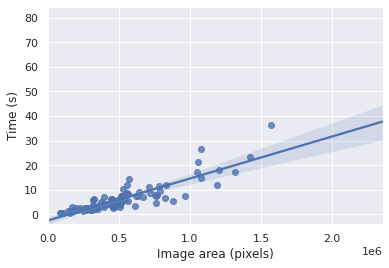

/tmp/ipykernel_5563/1645796135.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bb_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('./qualitative/stacked-time-by-area-all-gpu.pdf', bb_inches='tight', pad_inches=0)


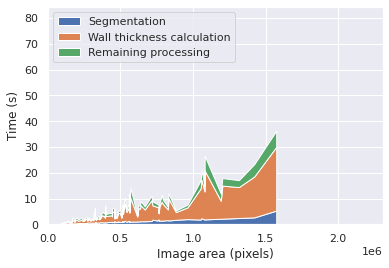

In [12]:
import pandas as pd
import seaborn as sns

sns.set_theme()

times = pd.read_csv('./qualitative/all_times_all_gpu.csv')
# times = pd.read_csv(out_file)
times.sort_values(by='area', inplace=True)

# sns.regplot(x='area', y='seg', data=times, label='Segmentation')
# sns.regplot(x='area', y='vect', data=times, label='Vectorization')
# sns.regplot(x='area', y='wall_width', data=times, label='Wall width')
# plt.legend()
plt.xlim((0, M+0.05e6))
# plt.ylim(ylim)
plt.ylim((-4, 84.3799688498647))
sns.regplot(x='area', y='total', data=times, label='Total', truncate=False)
plt.ylabel('Time (s)')
plt.xlabel('Image area (pixels)')
plt.savefig('./qualitative/time-by-area-all-gpu.pdf', bb_inches='tight', pad_inches=0)
plt.show()

remaining = times.vect + times["att+norm"] + times.smbl_class

plt.stackplot(
    times.area, times.seg, times.wall_width, remaining, 
    labels=['Segmentation', 'Wall thickness calculation', 'Remaining processing'])
plt.legend(loc='upper left')
plt.ylabel('Time (s)')
plt.xlabel('Image area (pixels)')
plt.xlim((0, M))
plt.ylim((0, 84.3799688498647))
plt.savefig('./qualitative/stacked-time-by-area-all-gpu.pdf', bb_inches='tight', pad_inches=0)

In [13]:
times["seg/total"] = times.seg/times.total * 100
times["width/total"] = times.wall_width/times.total * 100
times["smbl_class/total"] = times.smbl_class/times.total * 100
times["remaining/total"] = remaining/times.total * 100
times.describe()

,i,area,seg,vect,wall_width,smbl_class,att,norm,att+norm,total,seg/total,width/total,smbl_class/total,remaining/total
count,99.000000,9.900000e+01,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,49.191919,5.127547e+05,1.034183,0.993729,3.996521,0.234716,0.017838,0.002073,0.019911,6.279061,21.541929,57.854282,4.569064,20.603789
std,28.994256,2.974799e+05,0.675865,1.021649,4.120983,0.134742,0.016966,0.000623,0.017397,5.790095,10.079837,9.899056,1.767884,5.781686
min,0.000000,8.958500e+04,0.234711,0.044924,0.103560,0.011273,0.001334,0.001097,0.002431,0.400668,7.150312,23.914503,0.882324,8.466722
25%,24.500000,3.183640e+05,0.631071,0.373615,1.396814,0.111617,0.006737,0.001614,0.008246,2.664061,14.601310,53.131661,3.452851,16.563330
50%,49.000000,4.601910e+05,0.876991,0.700622,2.919515,0.236605,0.011916,0.001971,0.013791,4.754785,18.644147,59.558077,4.668958,19.498535
75%,73.500000,6.201665e+05,1.265225,1.171515,4.893784,0.328342,0.022358,0.002332,0.024526,7.542525,26.698914,64.844194,5.478953,23.507611
max,99.000000,1.572816e+06,5.306713,5.695282,24.736746,0.565683,0.090575,0.004113,0.094688,36.304022,60.429262,73.290807,9.243646,39.110525
